In [83]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

import dask

import matplotlib.pyplot as plt

## Dask cluster

In [18]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=1,
    memory="8GB",
    walltime="00:10:00",
)

cluster.scale(jobs=5)

In [19]:
# print(cluster.job_script())

In [20]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.157:34143,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Available water capacity & wilting point

In [28]:
noah_dir = '/storage/group/pches/default/public/NLDAS/NOAH/input'
out_dir = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/'

In [29]:
# Read NOAH soil properties
ds_noah = xr.open_dataset(f'{noah_dir}/NLDAS_soil_Noah.nc4')

In [32]:
# Calculate awCap in mm/m
awCap = (1000 * (ds_noah['Noah_fieldcap'] - ds_noah['Noah_wiltingp'])).isel(time=0).drop('time')
ds_awCap = xr.Dataset({'awCap':awCap})

ds_awCap.awCap.attrs['units'] = 'mm/m'
ds_awCap.awCap.attrs['note'] = 'Calculated as NOAH field capacity minus wilting point'

# Store
ds_awCap.to_netcdf(f'{out_dir}/WBM/geo_inputs/NLDAS_NOAH_awCap.nc')

In [39]:
# Wilting point as fraction of awCap
wp = ds_noah['Noah_wiltingp'].isel(time=0).drop('time')
ds_wp = xr.Dataset({'wiltingp':1000 * wp / awCap})

ds_wp.wiltingp.attrs['units'] = 'fraction of awCap'
ds_wp.wiltingp.attrs['note'] = 'Calculated from NOAH'

# Store
ds_wp.to_netcdf(f'{out_dir}/WBM/geo_inputs/NLDAS_NOAH_wiltingp.nc')

## Leaf Area Index

In [95]:
data_dir = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/'

In [100]:
# GLDAS LAI based on AVHRR satellite, 20-year climatology from 1982 - 2001
# See: https://ldas.gsfc.nasa.gov/gldas/lai-greenness
ds_lai = xr.open_dataset(f'{data_dir}/WBM/geo_inputs/GLDASp5_CLSM_lai_025d.nc4', decode_times=False)

In [101]:
# Fix time coordinate
ds_lai['time'] = pd.date_range("2000-01-01", periods=12, freq='MS')

# Interpolatet to daily
ds_lai = ds_lai.interp(time=pd.date_range("2000-01-01", periods=366, freq='D'))

In [104]:
# Get NLDAS grid
nldas_grid = xr.open_dataset('/storage/group/pches/default/public/NLDAS/forcing/daily/NLDAS_FORA0125_H.A20221231.nc') # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

# Regrid conservatively
ds_out = xr.Dataset(
    {
        "lat": (["lat"], nldas_lat_grid, {"standard_name": "latitude", "units": "degrees_north"}),
        "lon": (["lon"], nldas_lon_grid, {"standard_name": "longitude", "units": "degrees_east"}),
    }
)

regridder = xe.Regridder(ds_lai, ds_out, 'bilinear')
ds_lai_out = regridder(ds_lai)

# Rename
ds_lai_out = ds_lai_out.rename({'GLDAS_Catchment-F2.5_LAI':'LAI'})

# Store 
ds_lai_out.to_netcdf(f"{data_dir}/WBM/geo_inputs/LAI_clima_NLDASgrid.nc")

## Cropland Data Layer for Kc timeseries

In [2]:
# Get NLDAS grid
nldas_grid = xr.open_dataset('/storage/group/pches/default/public/NLDAS/forcing/daily/NLDAS_FORA0125_H.A20221231.nc') # random date

nldas_lat_min = nldas_grid.lat.min()
nldas_lon_min = nldas_grid.lon.min()
nldas_lat_max = nldas_grid.lat.max()
nldas_lon_max = nldas_grid.lon.max()

# grid same in lat/lon
assert (nldas_grid.lat[1] - nldas_grid.lat[0]) == (nldas_grid.lon[1] - nldas_grid.lon[0])

nldas_spacing = nldas_grid.lat[1] - nldas_grid.lat[0]

In [3]:
# Define edges and centers
low_lon_edges = np.arange(nldas_lon_min - nldas_spacing/2, nldas_lon_max + nldas_spacing, nldas_spacing)
low_lat_edges = np.arange(nldas_lat_min - nldas_spacing/2, nldas_lat_max + nldas_spacing, nldas_spacing)

lon_centers = (low_lon_edges[:-1] + low_lon_edges[1:]) / 2
lat_centers = (low_lat_edges[:-1] + low_lat_edges[1:]) / 2

In [31]:
def _preprocess(ds):
    # Add time dimension
    ds = ds.assign_coords(time = int(ds.encoding['source'][59:63]))
    # Rename
    ds = ds.rename({'band_data':'CDL_value', 'x':'lon', 'y':'lat'}).sortby('lat')
    # Drop band
    ds = ds.isel(band=0).drop('band')

    return ds

In [ ]:
# Crop codes from Siebert & Döll (2010): https://www.sciencedirect.com/science/article/pii/S0022169409004235
# mapped to CDL classes
crop_codes = {'wheat': [],
              
    'corn':1, 'cotton':2, 'rice':3, 'sorghum':4, 'soybeans':5, 'sunflower':6,
             'peanuts':10, 'tobacco':11, 'sweet_corn':12, 'pop_or_corn':13, ''}

In [32]:
# Only include crops from Siebert & Döll (2010): https://www.sciencedirect.com/science/article/pii/S0022169409004235
def map_CDL_crops(ds):
    # Crop codes
    crop_codes = {'corn':1, 'cotton':2, 'rice':3, 'sorghum':4, 'soybeans':5, 'sunflower':6}

    # Map over all
    ds_dict_out = {}
    for key,value in crop_codes.items():
        ds_dict_out[key] = ds.CDL_value == value

    # Return
    return xr.Dataset(ds_dict_out)

In [33]:
ds = _preprocess(xr.open_dataset('/storage/group/pches/default/users/dcl5300/USDA_CDL/latlon/2016_30m_cdls.tif',
                     chunks='auto'))

In [34]:
CDL_agg = (
    map_CDL_crops(ds)
    .groupby_bins('lon', bins=low_lon_edges, labels=lon_centers)
    .sum(dim="lon")
    .groupby_bins('lat', bins=low_lat_edges, labels=lat_centers)
    .sum(dim="lat")
).compute()

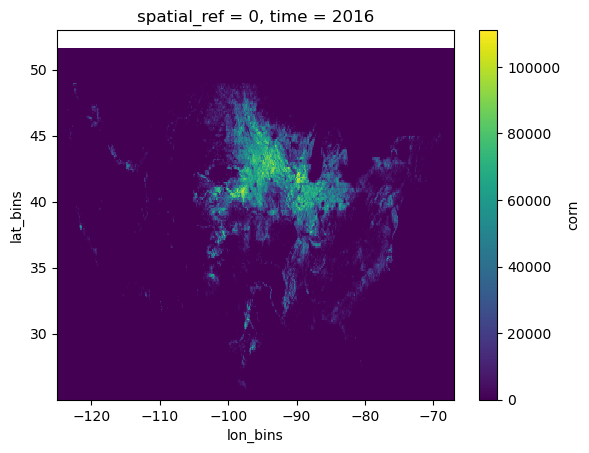

In [36]:
CDL_agg.corn.plot()

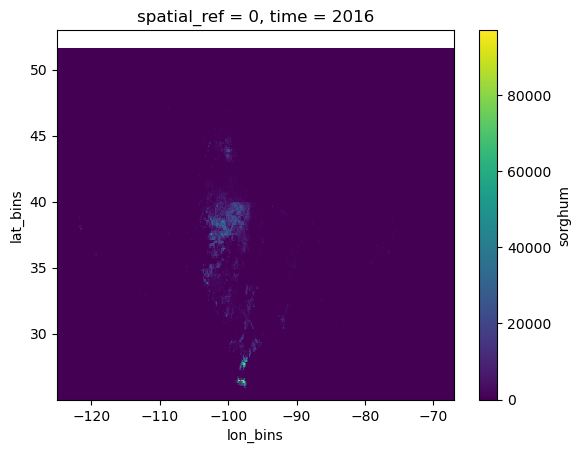

In [42]:
CDL_agg.sorghum.plot()